# Introduction
Regression on Taxi Trip Duration
NYC Taxi Dataset

Steps:
1. Load requirements
2. Build Simple Models
    1. Mean prediction - Baseline
    2. Distance, time columns only - Simplest, intuitive model
    3. Add more information and inspect performance
    4. Build a model with all columns
3. Improve Best performaing model from above
    1. Feature selection
    2. Hyperparameter Tuning
4. Conclusions, Ideas for further improvement

Dependencies:
 - data_preprocessing_helpers : functions to preprocess data and return DFs ready for modelling
 - modelling_helpers : functions to build and evaluate models


Conclusions:

1. Best Model
    - RF(max_depth = 10)
    - Columns: [
        'vendor_id_1', 
        'passenger_count', 
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
        'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 
        'log_distance', 'log_m_distance', 
        'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin',
        'total_distance', 'total_travel_time', 'number_of_steps',
        'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count']
    - Results: RMSE: 0.42, r2: 0.72, MAPE: 0.045, MAE: 0.28, RMSLE : 0.06
    - Grid Search takes time. 



2. Sparsest, best performing model
-   RF(max_depth = 10)    
    - Columns: ['log_distance', 'log_m_distance','passenger_count', 
    'vendor_id_1', 'pickup_dow', 'pickup_hour', 
    'total_distance', 'total_travel_time']
    - Results: RMSE: 0.43, r2: 0.70, MAPE: 0.047, MAE: 0.29, RMSLE : 0.06

Next Steps:
1. Explore and remove outliers. What are those highest value actuals?
2. Cluster Locations. You could also manually add the airport locations in those kaggle notebooks.
3. Ensembles
4. What's the best you can do with what's already available?
    1. From OSRM data, explore number of turns and length of sections. Freeways travel faster, small roads require more time. Turns slow the vehicle down.
    2. Weather and traffic data? 

In [143]:
%load_ext autoreload
%autoreload 2
#"notebook.output.textLineLimit": 500
#!unzip ./data/nyc_taxi_final.zip
#!unzip ./data/osrm/fastest_routes_train_part_1.zip
#!unzip ./data/osrm/fastest_routes_train_part_2.zip 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load
## Packages

In [144]:
import pandas as pd
import numpy as np

import data_preprocessing_helpers as dp
import data_explorer as de
import modeling_helpers as mh

import seaborn as sns

from sklearn.linear_model import LinearRegression as lin_reg
from sklearn.tree import DecisionTreeRegressor as dtree
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm



model_logs = dict()
model_logs['df'] = pd.DataFrame(columns = ['rmse', 'r2',
                                            'rmsle', 'mape', 'mae'])

def log_model(name, model_logs, model_performance):
    """
    Inputs:
        name :
        model_logs : dict()
        model_performance : Output of build_evaluate_model [scores, model, preds]
    
    """
    model_performance = {

    'scores': model_performance[0], 
    'model' : model_performance[1], 
    'preds' : model_performance[2] 
    }

    model_logs[name] = model_performance
    model_logs['df'] = pd.concat([model_logs['df'], 
                              pd.DataFrame(model_performance['scores'], 
                                           index = [name], 
                                           columns = model_logs['df'].columns)],
                                 axis = 0)
    
    return model_logs

## Data
Getting base data and the supplied OSRM Data.

In [145]:
df = dp.get_osrm_merged_data(update=False)
df

# Simple Models
Try out simple models to create baselines for performance.
- First, estimate the error for using the mean as the prediction.
- Then, use only distance.
- Then distance and timestamps.
- Then, add the OSRM distance data and we must expect a huge jump in the model's performance with the addition.

## 1. Base Model - Average

In [147]:
x_, y, xval_, yval = dp.split_data(df, target = 'trip_duration', validation_split = 0.25)

input data has 729296 rows
output data has 546972 + 182324 rows


In [148]:
mean_pred = y.mean()
mean_pred, np.exp(mean_pred), np.exp(mean_pred)/60

(6.467126766225391, 643.6317631563371, 10.727196052605619)

RMSE: 0.7943959513655329, r2: -1.26459527294287e-08, MAPE: 0.10043035596021962, MAE: 0.6052949946283244, RMSLE : 0.11283584394202047


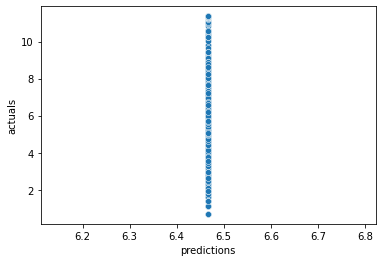

In [149]:
score, errors_base = mh.evaluate_predictions(preds = np.repeat(mean_pred, xval_.shape[0]), actuals = yval)

Now this is the basic prediction we want to beat. Let's see how many columns are required to do that.

## One Column Prediction

Building & Evaluating a Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
-----
input data has 729296 rows
Subsetting Columns ['trip_distance']
output data has 546972 + 182324 rows
Model Scores: 0.3897546655910137, 0.3913840853845332
RMSE: 0.6197387781986154, r2: 0.3913840853845332, MAPE: 0.07553068218037742, MAE: 0.4506768601056615, RMSLE : 0.09019637691419372
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['trip_distance']
CV Mean RMSE: 0.6205891399888674, Std: 0.0021753871147232326
-----


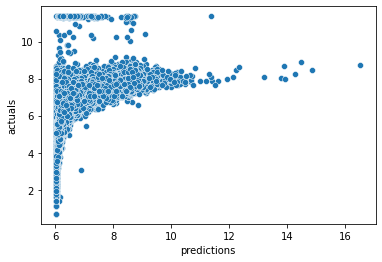

In [150]:
select_cols = ['trip_distance']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(StandardScaler(), lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

In [151]:
model_coefs = pd.DataFrame(model.named_steps.linearregression.coef_, index = model.feature_names_in_, columns = ['coef'])
model_coefs

,coef
trip_distance,0.496184


Building & Evaluating a LinearRegression()
-----
input data has 729296 rows
Subsetting Columns ['trip_distance']
output data has 546972 + 182324 rows
Model Scores: 0.3897546655910137, 0.3913840853845332
RMSE: 0.6197387781986154, r2: 0.3913840853845332, MAPE: 0.07553068218037742, MAE: 0.4506768601056615, RMSLE : 0.09019637691419372
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['trip_distance']
CV Mean RMSE: 0.6205891399888674, Std: 0.0021753871147232725
-----


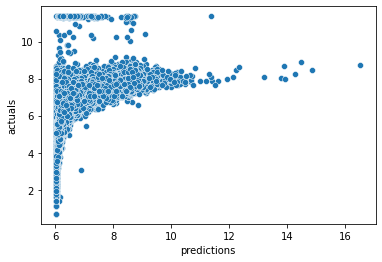

In [152]:
scores, model, pdf = mh.build_evaluate_model(model = lin_reg(), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

In [153]:
model_coefs = pd.DataFrame(model.coef_, 
                           index = model.feature_names_in_, columns = ['coef'])
model_intercept = pd.DataFrame(model.intercept_, 
                           index = ['intercept'], columns = ['coef'])
model_coefs = pd.concat([model_coefs, model_intercept], axis = 0)

In [154]:

model_coefs

,coef
trip_distance,0.126159
intercept,6.033776


### Observations:
1. This is an improvement over the average prediction. But from the graphs, we can still see a lot of scope for improvement. Now, after the basic hygiene check, we can proceed with adding more columns.
2. Trip distance alone captures some of the variance in the data. The R2 we get is about 0.39, much better than the zero we had before. 

Good beginning. Now, add more features

### Inspect LinReg model - stastsmodels

In [155]:
x, y = dp.split_data(df, target = 'trip_duration', include_cols = select_cols)
x, _ = mh.scale_x(x,x)
x_sm = sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_sm)
res = mod.fit()
print(res.summary())

input data has 729296 rows
Subsetting Columns ['trip_distance']
                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                 4.666e+05
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:15:34   Log-Likelihood:            -6.8689e+05
No. Observations:              729296   AIC:                         1.374e+06
Df Residuals:                  729294   BIC:                         1.374e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

# Slightly Larger Model

## Linear Regression


Building & Evaluating a Pipeline(steps=[('linearregression', LinearRegression())])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.5832949084452177, 0.5837395362995105
RMSE: 0.5125303659720669, r2: 0.5837395362995105, MAPE: 0.06039875035952781, MAE: 0.3648354232469531, RMSLE : 0.07473661228246857
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
CV Mean RMSE: 0.5129194431575824, Std: 0.0023570982317860745
-----


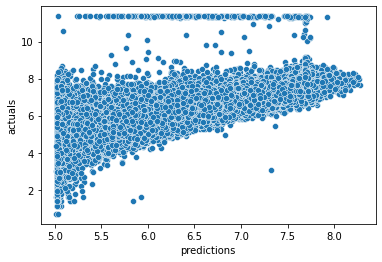

In [156]:
select_cols = ['log_distance', 'log_m_distance','passenger_count']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

The CV RMSE has reduced. R2 has improved to 58%. Good signs.

### Inspect Linear Regression

In [157]:
x, y = dp.split_data(df, target = 'trip_duration', include_cols = select_cols)
x, _ = mh.scale_x(x,x)
x_sm = sm.add_constant(x, prepend=False)
mod = sm.OLS(y, x_sm)
res = mod.fit()
print(res.summary())

input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                 3.404e+05
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:15:36   Log-Likelihood:            -5.4792e+05
No. Observations:              729296   AIC:                         1.096e+06
Df Residuals:                  729292   BIC:                         1.096e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

## DTree

Building & Evaluating a Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.6197566004502811, 0.6055147976768125
RMSE: 0.4989446587286763, r2: 0.6055147976768125, MAPE: 0.058006708766462314, MAE: 0.35437885180195544, RMSLE : 0.07157890355752992
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
CV Mean RMSE: 0.4983182532821077, Std: 0.002544013414248574
-----


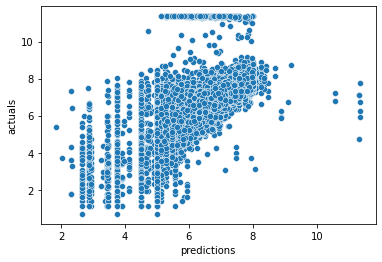

In [158]:
select_cols = ['log_distance', 'log_m_distance','passenger_count']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

## Random Forest

Building & Evaluating a Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.6253292178954146, 0.6120128750518682
RMSE: 0.49481821288009914, r2: 0.6120128750518683, MAPE: 0.05762837069151904, MAE: 0.35211785810496976, RMSLE : 0.07098265060157101
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
CV Mean RMSE: 0.4942654037400396, Std: 0.002153061075908483
-----


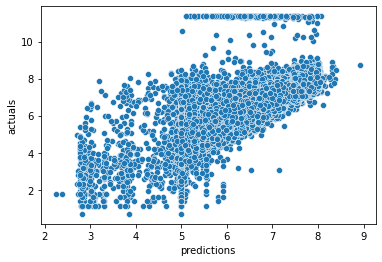

In [159]:

scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

## Ridge and Lasso Regression

Building & Evaluating a Ridge(alpha=0.75, random_state=1)
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.5832947025310549, 0.5837414740379671
RMSE: 0.5125291730279337, r2: 0.5837414740379671, MAPE: 0.06039925323409755, MAE: 0.36482639257007043, RMSLE : 0.07473911007188658
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
CV Mean RMSE: 0.5129195384398914, Std: 0.002358220978164427
-----
Building & Evaluating a Ridge(alpha=0.75, random_state=1)
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.5832949084257341, 0.5837395568516939
RMSE: 0.5125303533193901, r2: 0.5837395568516939, MAPE: 0.06039875709689462, MAE: 0.36483530979050605, RMSLE : 0.07473664279492369
Performing Cross Validation
input da

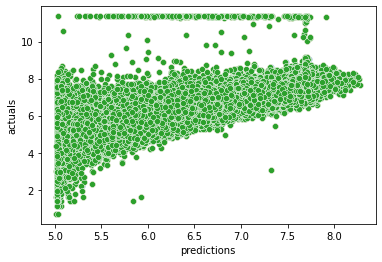

In [160]:

scores, model, pdf = mh.build_evaluate_model(
    model = Ridge(alpha=0.75, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = False)

scores, model, pdf = mh.build_evaluate_model(
    model = Ridge(alpha=0.75, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = True)

scores, model, pdf = mh.build_evaluate_model(
    model = Ridge(alpha=0.9, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = True)

In [161]:
ridge_coefs = pd.DataFrame(model.coef_, index = model.feature_names_in_, columns = ['coef'])
ridge_coefs['abs_coefs'] = ridge_coefs.coef.abs()
ridge_coefs.sort_values('abs_coefs')

,coef,abs_coefs
passenger_count,0.011033,0.011033
log_m_distance,-0.264473,0.264473
log_distance,0.836085,0.836085


Building & Evaluating a Lasso(alpha=0.75, random_state=1)
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.0, -1.26459527294287e-08
RMSE: 0.7943959513655329, r2: -1.26459527294287e-08, MAPE: 0.10043035596021962, MAE: 0.6052949946283244, RMSLE : 0.11283584394202047
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
CV Mean RMSE: 0.7946829128073583, Std: 0.0017732880147100804
-----
Building & Evaluating a Lasso(alpha=0.5, random_state=1)
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'passenger_count']
output data has 546972 + 182324 rows
Model Scores: 0.1675487037240022, 0.16800808187834693
RMSE: 0.724597069334823, r2: 0.16800808187834693, MAPE: 0.09108707742754785, MAE: 0.5466028404287708, RMSLE : 0.10389342618565485
Performing Cross Validation
input data has 729

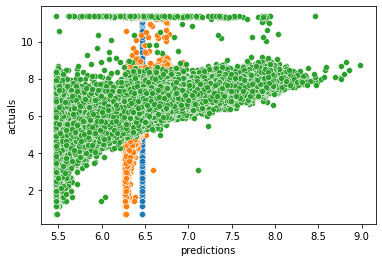

In [162]:

scores, model, pdf = mh.build_evaluate_model(
    model = Lasso(alpha=0.75, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = False)

scores, model, pdf = mh.build_evaluate_model(
    model = Lasso(alpha=0.5, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = True)

scores, model, pdf = mh.build_evaluate_model(
    model = Lasso(alpha=0.1, copy_X=True, random_state=1),
    df = df, 
    select_cols = select_cols, 
    scale = True)

In [163]:
rfe_ridge_cv = RFECV(estimator = model, 
            step=1, 
            min_features_to_select=6, 
            scoring=mh.scorer, verbose=3, 
            n_jobs=-1, importance_getter='auto')

rfe_ridge_cv.fit(x,y)

RFECV(estimator=Lasso(alpha=0.1, random_state=1), min_features_to_select=6,
      n_jobs=-1, scoring=make_scorer(mean_squared_error, squared=False),
      verbose=3)

In [164]:
rfe_ridge_cv.cv_results_

{'mean_test_score': array([0.53442121]),
 'std_test_score': array([0.00261365]),
 'split0_test_score': array([0.5301064]),
 'split1_test_score': array([0.53270409]),
 'split2_test_score': array([0.53645607]),
 'split3_test_score': array([0.53593972]),
 'split4_test_score': array([0.53689977])}

In [165]:
pd.DataFrame(rfe_ridge_cv.ranking_, index = rfe_ridge_cv.feature_names_in_)

,0
log_distance,1
log_m_distance,1
passenger_count,1


Conclusion: 
From above, we get the following results:
With the three columns, 
- linear_regression gets an RMSE of 
    RMSE: 0.5125303659720669, r2: 0.5837395362995105, MAPE: 0.06039875035952781, MAE: 0.3648354232469531, RMSLE : 0.07473661228246857

- Decision Tree gets:
    RMSE: 0.49887485324303316, r2: 0.6056251718609224, MAPE: 0.058004434075676715, MAE: 0.3543611865471854, RMSLE : 0.07157447726913327

- Random Forest gets:
    RMSE: 0.4948168742283305, r2: 0.6120149743236207, MAPE: 0.057625536187913294, MAE: 0.3521204917203583, RMSLE : 0.07098069189975349

So, the tree based methods are slightly better than the linear method.

Now, we add the pickup DOW and Time of Day variables to see improvement.

# A sparse model

Building & Evaluating a Pipeline(steps=[('linearregression', LinearRegression())])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
output data has 546972 + 182324 rows
Model Scores: 0.5890254530816181, 0.5894803983073907
RMSE: 0.5089838105698657, r2: 0.5894803983073907, MAPE: 0.05974071691390978, MAE: 0.3607285866444453, RMSLE : 0.07428659780269156
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
CV Mean RMSE: 0.5093862196765783, Std: 0.0022578062746334364
-----


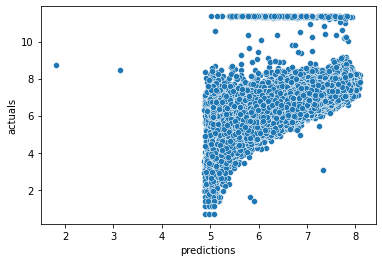

In [166]:
select_cols = ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

Building & Evaluating a Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
output data has 546972 + 182324 rows
Model Scores: 0.6695066456721953, 0.6538411473170427
RMSE: 0.46738496822776365, r2: 0.6538411473170427, MAPE: 0.05259929981531058, MAE: 0.32001991619830505, RMSLE : 0.0674083894614688
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
CV Mean RMSE: 0.4663289161417074, Std: 0.0024287403607169567
-----


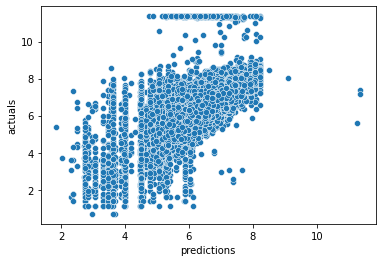

In [167]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

Building & Evaluating a Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
output data has 546972 + 182324 rows
Model Scores: 0.6764116550039838, 0.6612148061275829
RMSE: 0.46238020191298246, r2: 0.6612148061275828, MAPE: 0.05202171293952253, MAE: 0.3164280372818059, RMSLE : 0.06659001825280637
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour']
CV Mean RMSE: 0.46101425231988624, Std: 0.002537297284572993
-----


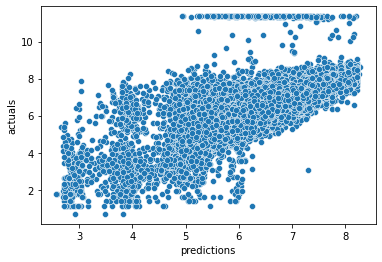

In [168]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

Conclusion: That's much better. We can see improving performance with adding information.

The RMSE has dropped to 46% with the random forest and added columns.

# A sparse model with better info

Building & Evaluating a Pipeline(steps=[('linearregression', LinearRegression())])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
output data has 546972 + 182324 rows
Model Scores: 0.6014229051786009, 0.6024013411160996
RMSE: 0.5009097380645862, r2: 0.6024013411160996, MAPE: 0.05846828341236181, MAE: 0.35267636465465574, RMSLE : 0.07333368374967648
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
CV Mean RMSE: 0.501559866585455, Std: 0.002313957332513978
-----


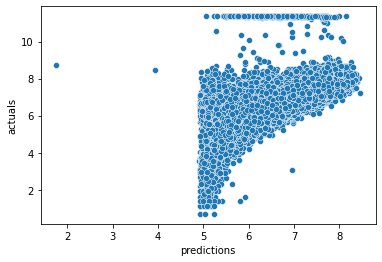

In [169]:
select_cols = ['log_distance', 'log_m_distance','cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 
               'total_distance', 'total_travel_time', 'number_of_steps']
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

Building & Evaluating a Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
output data has 546972 + 182324 rows
Model Scores: 0.7101444498999008, 0.6906380929697837
RMSE: 0.44184550125203637, r2: 0.6906380929697837, MAPE: 0.048246555465306144, MAE: 0.29441200320128413, RMSLE : 0.06370815274582334
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
CV Mean RMSE: 0.4400246977061258, Std: 0.002804853136165247
-----


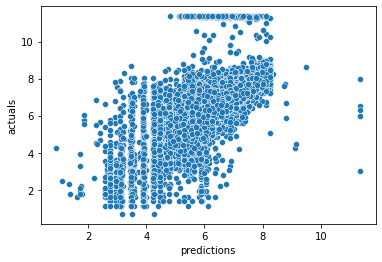

In [170]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

Building & Evaluating a Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1))])
-----
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
output data has 546972 + 182324 rows
Model Scores: 0.7189065617828505, 0.7023514920154759
RMSE: 0.4333999674089219, r2: 0.7023514920154759, MAPE: 0.04735961171747882, MAE: 0.2887551907803937, RMSLE : 0.06239229191430351
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['log_distance', 'log_m_distance', 'cosine_distance', 'passenger_count', 'vendor_id_1', 'pickup_dow', 'pickup_hour', 'total_distance', 'total_travel_time', 'number_of_steps']
CV Mean RMSE: 0.4319261721645421, Std: 0.0029142445319698808
-----


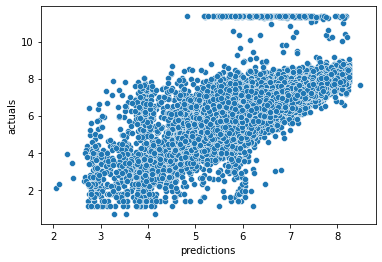

In [171]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

Conclusion: Adding the OSRM columns helped the random forest much more than the linear regression. Now our current best model has an RMSE of 43%, RMSLE of 0.06. That's great.

# Use All Columns

In [172]:
select_cols = [
    'vendor_id_1', 
    'passenger_count', 
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
    'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 
    'log_distance', 'log_m_distance', 
    'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin',
    'total_distance', 'total_travel_time', 'number_of_steps',
    'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count'
    ]

x,y = dp.split_data(df, target = 'trip_duration', include_cols=select_cols)


input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'total_distance', 'total_travel_time', 'number_of_steps', 'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count']


Building & Evaluating a Pipeline(steps=[('linearregression', LinearRegression())])
-----
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'total_distance', 'total_travel_time', 'number_of_steps', 'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count']
output data has 546972 + 182324 rows
Model Scores: 0.6190248580179076, 0.6193808675822524
RMSE: 0.4900973190952066, r2: 0.6193808675822524, MAPE: 0.05683457784415046, MAE: 0.34318692982334825, RMSLE : 0.07164062816903817
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour',

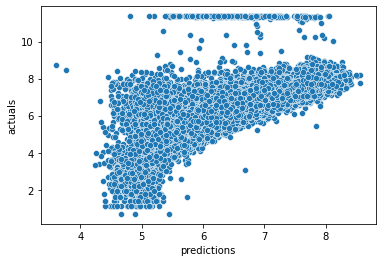

In [173]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(lin_reg()), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = True)

Building & Evaluating a Pipeline(steps=[('decisiontreeregressor', DecisionTreeRegressor(max_depth=10))])
-----
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'total_distance', 'total_travel_time', 'number_of_steps', 'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count']
output data has 546972 + 182324 rows
Model Scores: 0.7239265894948684, 0.7017007177413233
RMSE: 0.43387349834373157, r2: 0.7017007177413233, MAPE: 0.04678514019882838, MAE: 0.28548294492114845, RMSLE : 0.06261469204477325
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'picku

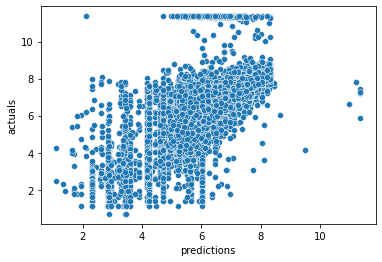

In [174]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(dtree(max_depth = 10)), 
                                df = df, 
                                select_cols = select_cols, 
                                scale = False)

Building & Evaluating a Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(max_depth=10, n_jobs=-1))])
-----
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'total_distance', 'total_travel_time', 'number_of_steps', 'cosine_distance', 'pickup_lat_bin_count', 'drop_lat_bin_count']
output data has 546972 + 182324 rows
Model Scores: 0.7376051720735197, 0.7175816802130548
RMSE: 0.42216619270162015, r2: 0.7175816802130548, MAPE: 0.04550211604348853, MAE: 0.2772387417936141, RMSLE : 0.06078517403439069
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['vendor_id_1', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup

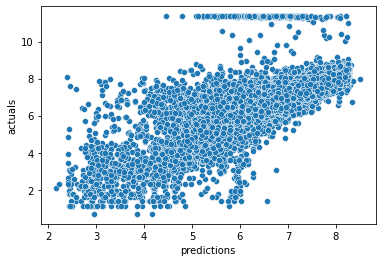

In [175]:
scores, model, pdf = mh.build_evaluate_model(
    model = make_pipeline(rf(max_depth = 10, n_jobs = -1)),
    df = df, 
    select_cols = select_cols,
    scale = False)

Conclusion: Adding all columns helped bring the RF's CV RMSE down to ~41%, the R2 is ~72%.
This is good.

The next strategies for improving performance are Hyperparameter Grid Search and Recursive Feature Selection.
Then, we will add more features like location information (airport, mall etc.)

# RFE

In [176]:
from sklearn.feature_selection import RFE

Building & Evaluating a DecisionTreeRegressor(max_depth=10)
-----
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'pickup_lat_bin_count', 'pickup_lon_bin_count', 'drop_lat_bin_count', 'drop_lon_bin_count', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'cosine_distance', 'vendor_id_1', 'total_distance', 'total_travel_time']
output data has 546972 + 182324 rows
Model Scores: 0.7257134675902328, 0.7007851211634353
RMSE: 0.4345388514802875, r2: 0.7007851211634353, MAPE: 0.04671951437716796, MAE: 0.2848107719910285, RMSLE : 0.06277933274616396
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', '

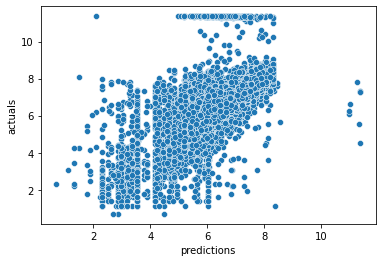

In [177]:

select_cols = ['passenger_count', 
'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin',
'pickup_lat_bin_count', 'pickup_lon_bin_count', 'drop_lat_bin_count', 'drop_lon_bin_count',
'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 
'log_distance', 'log_m_distance', 'cosine_distance',
'vendor_id_1', 
'total_distance', 'total_travel_time']

scores, model, pdf = mh.build_evaluate_model(
    model = dtree(max_depth = 10), 
    df = df, 
    select_cols = select_cols,
    scale = True)

Feature Importances

In [178]:
pd.DataFrame(model.feature_importances_, 
             index = model.feature_names_in_, 
             columns = ['feature_importance']).sort_values('feature_importance', ascending=False)

,feature_importance
total_distance,0.692146
total_travel_time,0.177323
pickup_hour,0.048268
log_distance,0.017532
dropoff_latitude,0.015567
pickup_dow,0.015494
cosine_distance,0.006019
dropoff_longitude,0.005789
drop_lat_bin_count,0.005740
log_m_distance,0.004886


In [179]:
x,y = dp.split_data(df, include_cols=select_cols, target='trip_duration')
rfe = RFE(estimator=model, verbose = 2).fit(x,y)
rfe.ranking_

input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'pickup_lat_bin_count', 'pickup_lon_bin_count', 'drop_lat_bin_count', 'drop_lon_bin_count', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'cosine_distance', 'vendor_id_1', 'total_distance', 'total_travel_time']
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


array([10,  1,  4,  1,  1, 11,  7,  8,  6,  9,  2,  1,  3,  1,  5, 12,  1,
        1,  1, 13,  1,  1,  1])

In [180]:
rfe_ranks = pd.DataFrame(rfe.ranking_, index = rfe.feature_names_in_, columns = ['rank_feature']).sort_values('rank_feature', ascending=False)
small_set_features = rfe_ranks[rfe_ranks.rank_feature==1].index
small_set_features

Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')

Building & Evaluating a DecisionTreeRegressor(max_depth=10)
-----
input data has 729296 rows
Subsetting Columns Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')
output data has 546972 + 182324 rows
Model Scores: 0.7238964555488332, 0.7010145044159275
RMSE: 0.43437225708143895, r2: 0.7010145044159275, MAPE: 0.046889198706738855, MAE: 0.2859527570481198, RMSLE : 0.06264778988819454
Performing Cross Validation
input data has 729296 rows
Subsetting Columns Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')
CV Mean RMSE: 0.4334713852068154, Std: 0.0023949618725239733
-----


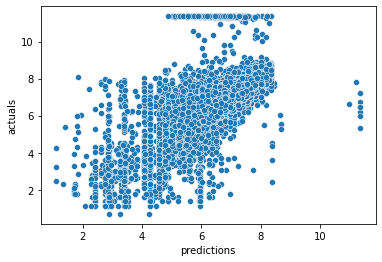

In [181]:
scores, model, pdf = mh.build_evaluate_model(
    model = dtree(max_depth = 10), 
    df = df, 
    select_cols = small_set_features,
    scale = True)

## RFE for Linear Regression

In [182]:
rfe_lr = RFECV(estimator = lin_reg(), 
            step=1, 
            min_features_to_select=6, 
            scoring=mh.scorer, verbose=3, 
            n_jobs=-1, importance_getter='auto')

rfe_lr.fit(x,y)

rfe_ranks_lr = pd.DataFrame(rfe_lr.ranking_, index = rfe_lr.feature_names_in_, columns = ['rank_feature']).sort_values('rank_feature', ascending=False)
small_set_features_lr = rfe_ranks_lr[rfe_ranks_lr.rank_feature==1].index
small_set_features_lr

Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 22 features.
Fitting estimator with 22 features.
Fitting estimator with 22 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 18 features.
Fitting estimator with 18 fe

Index(['drop_lat_bin', 'pickup_lat_bin', 'dropoff_latitude', 'log_m_distance',
       'cosine_distance', 'pickup_latitude'],
      dtype='object')

Conclusion: The DTree got a minimal drop in performance despite the reduction in features. Couldn't get an improvement. 

In [183]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator = dtree(max_depth =10), 
            step=0.5, 
            min_features_to_select=6, 
            scoring=mh.scorer, verbose=2, 
            n_jobs=-1, importance_getter='auto')

In [184]:
rfecv.fit(x,y)

Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 23 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 12 features.
Fitting estimator with 23 features.
Fitting estimator with 12 features.


RFECV(estimator=DecisionTreeRegressor(max_depth=10), min_features_to_select=6,
      n_jobs=-1, scoring=make_scorer(mean_squared_error, squared=False),
      step=0.5, verbose=2)

In [185]:
rfecv_ranks = pd.DataFrame(rfecv.ranking_, index = rfecv.feature_names_in_, 
                         columns = ['rank_feature']).sort_values('rank_feature', ascending=False)
rfecv_ranks

,rank_feature
passenger_count,3
pickup_doy,3
pickup_latitude,3
cosine_distance,3
pickup_lat_bin,3
drop_lat_bin,3
drop_lon_bin,3
pickup_lat_bin_count,3
pickup_lon_bin_count,3
pickup_week,3


# Grid Search

## Decision Tree

In [186]:
dt_params = {
    'max_depth' : [10,100],
    'min_samples_split' : [100, 500, 1000],
    'min_samples_leaf' : [100],
    'max_features' : [10,100],
#    'max_leaf_nodes' : [10,100]
}
grid_scv = GridSearchCV(estimator=dtree(), param_grid = dt_params, scoring = mh.scorer, verbose = 3, n_jobs=-1,)

In [187]:
x,y = dp.split_data(df, include_cols=small_set_features, target='trip_duration')
grid_scv.fit(x, y)

input data has 729296 rows
Subsetting Columns Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=100;, score=0.424 total time=   5.5s
[CV 3/5] END max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=100;, score=0.429 total time=   5.5s
[CV 2/5] END max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=100;, score=0.429 total time=   5.6s
[CV 4/5] END max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=100;, score=0.430 total time=   5.3s
[CV 5/5] END max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=100;, score=0.433 total time=   5.4s
[CV 1/5] END max_depth=10, max_features=10, 

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 100], 'max_features': [10, 100],
                         'min_samples_leaf': [100],
                         'min_samples_split': [100, 500, 1000]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=3)

In [188]:
grid_scv.best_estimator_

DecisionTreeRegressor(max_depth=10, max_features=10, min_samples_leaf=100,
                      min_samples_split=1000)

Building & Evaluating a DecisionTreeRegressor(max_depth=10, max_features=10, min_samples_leaf=100,
                      min_samples_split=1000)
-----
input data has 729296 rows
Subsetting Columns Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')
output data has 546972 + 182324 rows
Model Scores: 0.7112234145257135, 0.702648475809383
RMSE: 0.43318369740335366, r2: 0.702648475809383, MAPE: 0.047092130921536406, MAE: 0.28641061863327427, RMSLE : 0.06269580973720437
Performing Cross Validation
input data has 729296 rows
Subsetting Columns Index(['log_distance', 'total_distance', 'vendor_id_1', 'log_m_distance',
       'drop_lat_bin_count', 'pickup_hour', 'pickup_dow', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude', 'total_travel_time'],
      dtype='object')
CV Mean RMSE: 0.4309

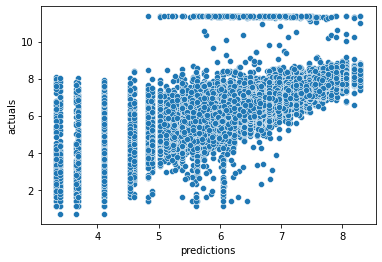

In [189]:
scores, model, pdf = mh.build_evaluate_model(
    model = dtree(max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=1000), 
    df = df, 
    select_cols = small_set_features,
    scale = True)

Building & Evaluating a DecisionTreeRegressor(max_depth=10, max_features=10, min_samples_leaf=100,
                      min_samples_split=1000)
-----
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'pickup_lat_bin_count', 'pickup_lon_bin_count', 'drop_lat_bin_count', 'drop_lon_bin_count', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'cosine_distance', 'vendor_id_1', 'total_distance', 'total_travel_time']
output data has 546972 + 182324 rows
Model Scores: 0.7025130636463908, 0.6929367541064577
RMSE: 0.4402009115975792, r2: 0.6929367541064577, MAPE: 0.04833911482802029, MAE: 0.2945329975169517, RMSLE : 0.06360314239131917
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dro

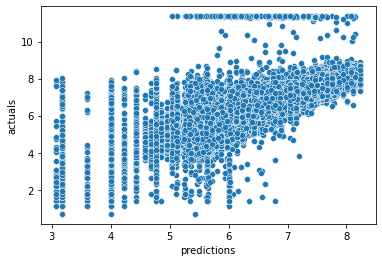

In [190]:
scores, model, pdf = mh.build_evaluate_model(
    model = dtree(max_depth=10, max_features=10, min_samples_leaf=100, min_samples_split=1000), 
    df = df, 
    select_cols = select_cols,
    scale = True)

## Random Forest

In [ ]:
rf_params = {
    'max_depth' : [10,100],
#    'min_samples_split' : [2, 100, 500, 1000],
#'min_samples_leaf' : [1,10,100],
    'max_features' : [10,100],
#    'max_leaf_nodes' : [10,100]
}
grid_scv_rf = GridSearchCV(estimator=rf(), param_grid = rf_params, scoring = mh.scorer, verbose = 3, n_jobs=-1)
grid_scv_rf.fit(x,y)

Conclusion:
The Grid Search also yields a minimal improvement over the existing params. A wider search may yield better results, but due to the time it takes, it is left for a later date.

# Ensemble Prediction

Building & Evaluating a LinearRegression()
-----
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'pickup_lat_bin_count', 'pickup_lon_bin_count', 'drop_lat_bin_count', 'drop_lon_bin_count', 'pickup_dow', 'pickup_doy', 'pickup_week', 'pickup_hour', 'log_distance', 'log_m_distance', 'cosine_distance', 'vendor_id_1', 'total_distance', 'total_travel_time']
output data has 546972 + 182324 rows
Model Scores: 0.6181831312890527, 0.6183938216928346
RMSE: 0.4907323835035973, r2: 0.6183938216928346, MAPE: 0.05699325106363911, MAE: 0.34395329980368844, RMSLE : 0.0717600286278996
Performing Cross Validation
input data has 729296 rows
Subsetting Columns ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_lat_bin', 'pickup_lon_bin', 'drop_lat_bin', 'drop_lon_bin', 'pickup_lat_bin_co

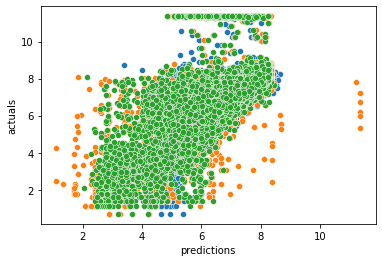

In [192]:
scores_lr, model_lr, pdf_lr = mh.build_evaluate_model(
    model = lin_reg(), 
    df = df, 
    select_cols = select_cols,
    scale = True)
model_logs = log_model('lin_reg', model_logs, [scores_lr, model_lr, pdf_lr])

scores_dt, model_dt, pdf_dt = mh.build_evaluate_model(
    model = dtree(max_depth=10), 
    df = df, 
    select_cols = small_set_features,
    scale = True)

model_logs = log_model('decision_tree', model_logs, [scores_dt, model_dt, pdf_dt])

scores_rf, model_rf, pdf_rf = mh.build_evaluate_model(
    model = rf(max_depth=10, n_jobs = -1), 
    df = df, 
    select_cols = small_set_features,
    scale = True)

model_logs = log_model('rf', model_logs, [scores_rf, model_rf, pdf_rf])

In [193]:
xtrain, xval, ytrain, yval = train_test_split(x, y, random_state = 56, test_size = 0.25)

In [194]:
preds_ens = pd.DataFrame()
preds_ens['lr_pred'] = pdf_lr['predictions']
preds_ens['dt_pred'] = pdf_dt['predictions']
#preds_ens['rf_pred'] = pdf_rf['predictions']
#preds_ens['avg_pred'] = (preds_ens['lr_pred'] + preds_ens['dt_pred'] + preds_ens['rf_pred'])/3
preds_ens['avg_pred'] = (preds_ens['lr_pred'] + preds_ens['dt_pred'])/2
preds_ens

,lr_pred,dt_pred,avg_pred
id,,,
id0572737,5.752631,5.427143,5.589887
id3700881,5.918559,5.495115,5.706837
id2828774,6.878959,6.641453,6.760206
id1462002,5.942728,6.087128,6.014928
id2531592,5.988582,6.038006,6.013294
...,...,...,...
id1654108,6.128180,6.431658,6.279919
id3212305,6.601956,6.646680,6.624318
id2661133,7.387815,7.237581,7.312698


RMSE: 0.44216620843942384, r2: 0.6901888382255524, MAPE: 0.049332078375682854, MAE: 0.2985897133790878, RMSLE : 0.06424333789355499


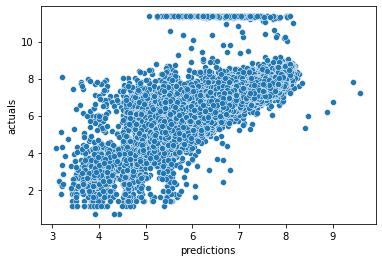

In [195]:
ens_pred = list(preds_ens['avg_pred'])
errors_ens, preds_ens = mh.evaluate_predictions(actuals = yval, preds = ens_pred)

In [196]:

model_logs = log_model('ensemble', model_logs, [errors_ens, None, preds_ens])

Conclusion: The Average prediction has a worse performance than the best RF model.

# Evaluating Predictions on Actual Values

In [197]:
preds_ens['predictions_e'] = np.exp(preds_ens['predictions']) - 1
preds_ens['actuals_e'] = np.exp(preds_ens['actuals']) - 1
preds_ens['error_e'] = preds_ens['actuals_e'] - preds_ens['predictions_e']
preds_ens['p_error_e'] = (preds_ens['actuals_e'] - preds_ens['predictions_e'])/preds_ens['actuals_e']
preds_ens

,predictions,actuals,error,predictions_e,actuals_e,error_e,p_error_e
id,,,,,,,
id0572737,5.589887,5.117994,-0.471893,266.705378,166.0,-100.705378,-0.606659
id3700881,5.706837,5.624018,-0.082820,299.917829,276.0,-23.917829,-0.086659
id2828774,6.760206,6.841615,0.081409,861.819911,935.0,73.180089,0.078267
id1462002,6.014928,5.820083,-0.194845,408.496379,336.0,-72.496379,-0.215763
id2531592,6.013294,5.786897,-0.226397,407.827841,325.0,-82.827841,-0.254855
...,...,...,...,...,...,...,...
id1654108,6.279919,6.272877,-0.007042,532.745492,529.0,-3.745492,-0.007080
id3212305,6.624318,6.687109,0.062790,752.190504,801.0,48.809496,0.060936
id2661133,7.312698,7.678789,0.366091,1498.216385,2161.0,662.783615,0.306702


RMSE: 3138.8385561186064, r2: 0.03071847943694095, MAPE: 0.3367132541610079, MAE: 334.148109289118, RMSLE : 0.44216620843942384


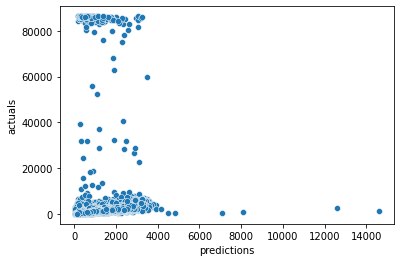

In [198]:
preds_n = list(preds_ens['predictions_e'])
actuals_n = preds_ens['actuals_e']
errors_ens_exp, preds_ens_exp = mh.evaluate_predictions(preds_n, actuals_n)

model_logs = log_model('ensemble', model_logs, [errors_ens_exp, None, preds_ens_exp])

In [201]:
model_logs['df'].sort_values('rmse')

,rmse,r2,rmsle,mape,mae
rf,0.422927,0.716563,0.060934,0.045645,0.278054
decision_tree,0.433951,0.701594,0.062575,0.046872,0.285858
ensemble,0.442166,0.690189,0.064243,0.049332,0.29859
lin_reg,0.490732,0.618394,0.07176,0.056993,0.343953
ensemble,3138.838556,0.030718,0.442166,0.336713,334.148109


Conclusion: The RF is the best performing model.